<a href="https://www.kaggle.com/code/vrenganathan/spotify-song-popularity-prediction-ml-models?scriptVersionId=108997974" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="text-align:center;">  Spotify Top Hits - Notebook for EDA & Predictive Model for Popularity Ratings </p>
![Spotify](http://storage.googleapis.com/pr-newsroom-wp/1/2018/11/Spotify_Logo_CMYK_Green.png)
 

<div class="alert alert-block alert-info">


## In this notebook I have covered the following 
##### * EDA - Checking distributions of each variable, handling categorical variables, 
##### * Feature extraction from Text data
##### * Setting up ML Pipeline 
##### * Best practices to avoid data leakage 
##### * Comparing the performane of models <b>

</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import re
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph.

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


import re
import nltk
import spacy
import string

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-hits-spotify-from-20002019/songs_normalize.csv


In [2]:
# Read Datasets
data1 = pd.read_csv('/kaggle/input/top-hits-spotify-from-20002019/songs_normalize.csv')

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">   
Quick EDA before we set aside 20% for test data and do any preprocessing work
</p>
</div>

In [3]:
data1.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'genre'], dtype='object')

In [4]:
data1.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
artist,2000,835,Rihanna,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
song,2000,1879,Sorry,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_ms,2000.0,NaN,NaN,NaN,228748.1245,39136.569008,113000.0,203580.0,223279.5,248133.0,484146.0
explicit,2000,2,False,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2000.0,NaN,NaN,NaN,2009.494,5.85996,1998.0,2004.0,2010.0,2015.0,2020.0
popularity,2000.0,NaN,NaN,NaN,59.8725,21.335577,0.0,56.0,65.5,73.0,89.0
danceability,2000.0,NaN,NaN,NaN,0.667438,0.140416,0.129,0.581,0.676,0.764,0.975
energy,2000.0,NaN,NaN,NaN,0.720366,0.152745,0.0549,0.622,0.736,0.839,0.999
key,2000.0,NaN,NaN,NaN,5.378,3.615059,0.0,2.0,6.0,8.0,11.0
loudness,2000.0,NaN,NaN,NaN,-5.512434,1.933482,-20.514,-6.49025,-5.285,-4.16775,-0.276


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">   
Very intersesting features :) Although I dont know how they have quantified acousticness,liveness etc in to a metric
</p>
</div>

In [6]:
data1.sample(10)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1600,The Weeknd,Starboy,230453,True,2016,0,0.681,0.594,7,-7.028,1,0.2820,0.165000,0.000003,0.1340,0.535,186.054,"pop, R&B"
1699,Drake,Too Good,263373,True,2016,74,0.794,0.653,7,-7.839,1,0.1040,0.048900,0.000049,0.1000,0.397,117.996,"hip hop, pop, R&B"
1449,Tove Lo,Talking Body,238426,True,2014,66,0.736,0.761,4,-5.449,0,0.0338,0.096600,0.000000,0.0823,0.114,119.999,"pop, Dance/Electronic"
1589,Zedd,I Want You To Know,238800,False,2015,0,0.561,0.877,9,-2.215,0,0.0659,0.006210,0.000008,0.2800,0.375,130.003,"hip hop, pop, Dance/Electronic"
854,P!nk,So What,215160,True,2008,76,0.534,0.870,11,-3.078,0,0.0425,0.000334,0.000000,0.2410,0.462,126.019,pop
444,Avant,Read Your Mind,263506,False,2003,56,0.755,0.381,8,-6.696,0,0.0711,0.291000,0.000005,0.0974,0.695,73.108,"pop, R&B"
1158,Rihanna,What's My Name?,263173,False,2010,66,0.692,0.786,2,-2.959,1,0.0690,0.230000,0.000000,0.0797,0.583,100.025,"hip hop, pop, R&B"
919,Agnes,Release Me,256213,False,2009,65,0.621,0.923,2,-3.124,0,0.0321,0.006450,0.000073,0.1080,0.716,127.973,"pop, Dance/Electronic"
746,Sugababes,About You Now,212400,False,2007,66,0.584,0.699,1,-6.065,0,0.0378,0.000065,0.000061,0.4860,0.585,82.499,"pop, R&B"
1880,DJ Khaled,No Brainer,260000,True,2018,67,0.552,0.760,0,-4.706,1,0.3420,0.073300,0.000000,0.0865,0.639,135.702,"hip hop, pop"


In [7]:
data1.shape

(2000, 18)

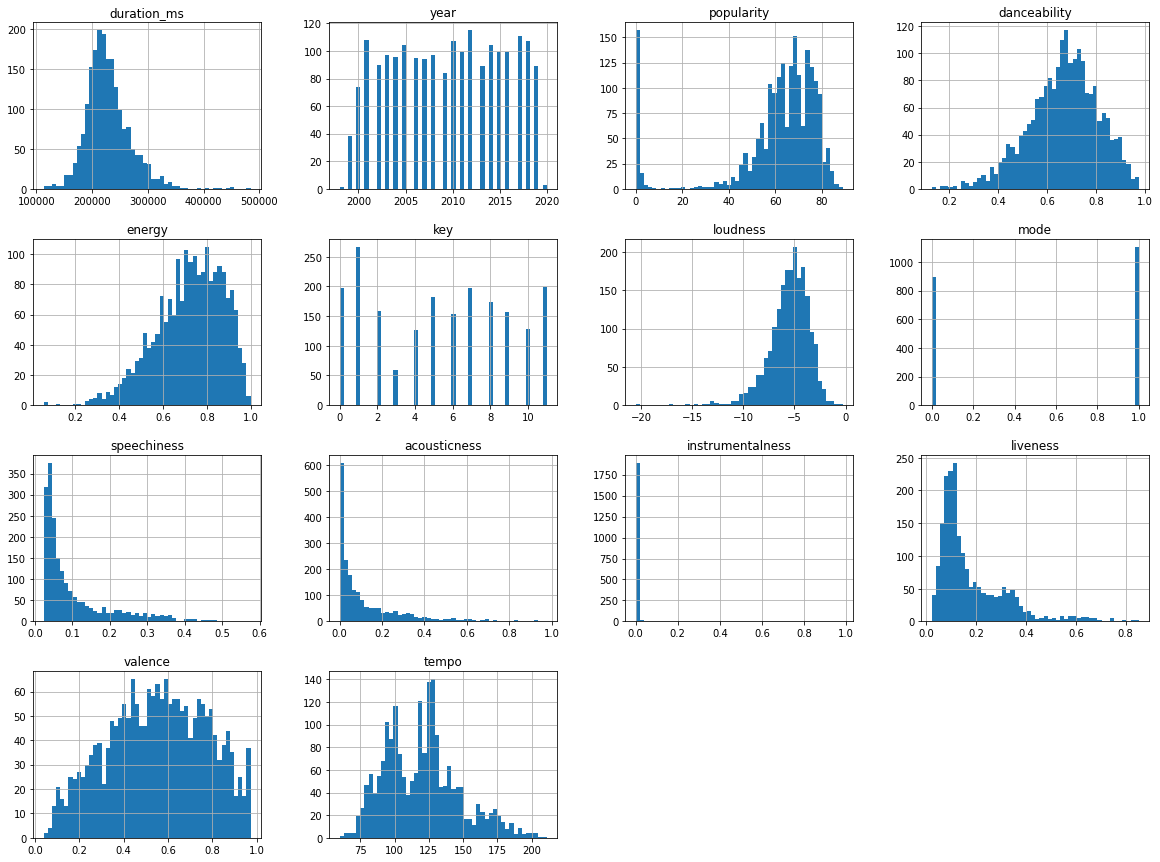

In [8]:
data1.hist(bins=50,figsize=(20,15))
plt.show()

In [9]:
data1['popularity'].value_counts(dropna = False)

0     126
69     76
68     75
73     69
74     69
     ... 
88      1
89      1
87      1
8       1
7       1
Name: popularity, Length: 76, dtype: int64

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">  
It is actually best to categorize the popularity (Dependent Variable) in to different categories such as Low/Med,High. This will convert the problem to classification instead of regression. There is no gain predicting the exact numeric value of rating
</p>
</div>

In [10]:
data1["popularity_rev"]=pd.cut(data1["popularity"],
                              bins = [0,70,89],
                              labels = [0,1],include_lowest=True)

In [11]:
data1["popularity_rev"].value_counts(dropna=False,normalize=True)*100

0    66.45
1    33.55
Name: popularity_rev, dtype: float64

<div class="alert alert-block alert-info"> 📌 

# Set Aside test data of 20% and forget about it. This is to ensure that we don't commit any 'data snooping' bias. While splitting use stratified sampling based on the popularity split


In [12]:
split= StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=7)
for train_index,test_index in split.split(data1,data1["popularity_rev"]):
    strat_train=data1.loc[train_index]
    strat_test=data1.loc[test_index]


#train_set,test_set = train_test_split(data1,test_size = 0.2,random_state = 7)

In [13]:
strat_train["popularity_rev"].value_counts(dropna=False,normalize=True)*100

0    66.4375
1    33.5625
Name: popularity_rev, dtype: float64

<div class="alert alert-block alert-info"> 📌 

### We can observe that the proportion of DV (Popularity) is maintained in the train & test dataset


In [14]:
#Check the shape of new dataset
strat_train.shape

(1600, 19)

# From this point we will work only on the training set (80%) of the records from the original dataset

In [15]:
missing_value = strat_train.isnull().sum().sort_values(ascending = False)
missing_perc = (strat_train.isnull().sum()*100/strat_train.shape[0]).sort_values(ascending = False)
value = pd.concat([missing_value,missing_perc],axis=1,keys=['Count','%'])
display(value.head(20).style.background_gradient(cmap = 'Reds', axis = 0))

,Count,%
artist,0,0.000000
mode,0,0.000000
genre,0,0.000000
tempo,0,0.000000
valence,0,0.000000
liveness,0,0.000000
instrumentalness,0,0.000000
acousticness,0,0.000000
speechiness,0,0.000000
loudness,0,0.000000


In [16]:
skew = pd.Series(strat_train.skew(),name="skew")
kurtosis = pd.Series(strat_train.kurtosis(),name="kurtosis")
pd.concat([skew,kurtosis],axis =1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,skew,kurtosis
duration_ms,1.005327,3.133773
explicit,1.019327,-0.962177
year,-0.049445,-1.190776
popularity,-1.843241,2.807396
danceability,-0.374672,0.005974
energy,-0.679499,0.328753
key,-0.033173,-1.293451
loudness,-1.344988,4.851582
mode,-0.196117,-1.963995
speechiness,1.816561,2.946396


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">  
Interpreting Skewness & Kurtosis

<p style="padding: 10px;
              color:white; 
                  text-align:center;"> 

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed If the skewness is less than -1 or greater than 1, the data are highly skewed

A normal distribution has kurtosis exactly 3. Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic. A distribution with kurtosis <3 is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader. A distribution with kurtosis >3 is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper

We can observe that features like Liveness, Instrumentalness, Acousticness, Loudness have skewed distributions. We might require preprocessing to converge faster

#### Now let's start looking in to each individual feature and decide the transformation before feeding in to the model. Since there are only handful of them, let's not process them in bulk. We shall individually check and engineer them.

In [17]:
# # Feature 1: Duration of track
strat_train['duration_ms'].describe()

count      1600.000000
mean     228112.064375
std       38979.193036
min      113000.000000
25%      202780.000000
50%      222420.000000
75%      247046.000000
max      484146.000000
Name: duration_ms, dtype: float64

In [18]:
# Feature 1: Converting ms to minute for better interpretation
(strat_train['duration_ms']/60000).describe()

count    1600.000000
mean        3.801868
std         0.649653
min         1.883333
25%         3.379667
50%         3.707000
75%         4.117433
max         8.069100
Name: duration_ms, dtype: float64

In [19]:
# Feature 2: Explicit
(strat_train['explicit']).value_counts(dropna=False,normalize=True)

False    0.726875
True     0.273125
Name: explicit, dtype: float64


### About ~28% of the songs have explicit content. 
#### We need to convert this feature to binary (1/0) for feeding to the model

In [20]:
# Feature 3: Year
(strat_train['year']).value_counts(dropna=False)

2018    90
2001    90
2012    89
2017    86
2008    85
2014    84
2011    83
2010    83
2016    81
2004    78
2007    78
2003    78
2015    77
2005    75
2006    73
2019    71
2013    69
2002    69
2009    68
2000    59
1999    31
2020     2
1998     1
Name: year, dtype: int64

In [21]:
# May be better to create age variable for the song with the current year-2022

strat_train['age'] = 2022 - strat_train['year'] 
strat_test['age'] = 2022 - strat_test['year'] 


In [22]:
strat_train['age'].value_counts(dropna=False)

4     90
21    90
10    89
5     86
14    85
8     84
11    83
12    83
6     81
18    78
15    78
19    78
7     77
17    75
16    73
3     71
9     69
20    69
13    68
22    59
23    31
2      2
24     1
Name: age, dtype: int64

In [23]:
# we can possibly create some bins 

strat_train["age_rev"]=pd.cut(strat_train["age"],
                              bins = [0,5,15,30],
                              labels = [1,2,3],include_lowest=True)

In [24]:
strat_test["age_rev"]=pd.cut(strat_test["age"],
                              bins = [0,5,15,30],
                              labels = [1,2,3],include_lowest=True)

In [25]:
strat_train["age_rev"].value_counts(dropna=False)

2    797
3    554
1    249
Name: age_rev, dtype: int64

In [26]:
# Feature 4: Danceability - A value of 0.0 is least danceable and 1.0 is most danceable.
(strat_train['danceability']).describe()

count    1600.000000
mean        0.669162
std         0.138791
min         0.129000
25%         0.583000
50%         0.676000
75%         0.765000
max         0.975000
Name: danceability, dtype: float64

In [27]:
# Feature 5: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
(strat_train['energy']).describe()

count    1600.000000
mean        0.722541
std         0.152384
min         0.054900
25%         0.626000
50%         0.741000
75%         0.838250
max         0.999000
Name: energy, dtype: float64

In [28]:
# Feature 6: Key - he key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. 
(strat_train['key']).describe()

count    1600.000000
mean        5.450000
std         3.607545
min         0.000000
25%         2.000000
50%         6.000000
75%         8.000000
max        11.000000
Name: key, dtype: float64

In [29]:
# This should be used as categorical as each value denotes a particular pitch. Hence there is no inherent order
(strat_train['key']).value_counts(dropna=False)

1     208
11    164
7     159
0     151
8     146
5     140
9     128
2     125
6     121
4     104
10    103
3      51
Name: key, dtype: int64

In [30]:
# Feature 7: Loudness - Values typically range between -60 and 0 db. 
(strat_train['loudness']).describe()

count    1600.000000
mean       -5.485694
std         1.903928
min       -20.514000
25%        -6.446250
50%        -5.218000
75%        -4.155500
max        -0.740000
Name: loudness, dtype: float64

In [31]:
# Feature 8: mode: Mode indicates the modality (major or minor) of a track,
#the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
(strat_train['mode']).value_counts(dropna=False)

1    878
0    722
Name: mode, dtype: int64

In [32]:
# Feature 10: mspeechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like 
#the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values 
#above 0.66 describe tracks that are probably made entirely of spoken words. 
#Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, 
#including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
strat_train['speechiness'].describe()

count    1600.000000
mean        0.102221
std         0.095040
min         0.023200
25%         0.039500
50%         0.059400
75%         0.127000
max         0.576000
Name: speechiness, dtype: float64

In [33]:
#Feature 11: acousticness: A confidence measure from 0.0 to 1.0 
#of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
strat_train['acousticness'].describe()

count    1600.000000
mean        0.130273
std         0.174268
min         0.000019
25%         0.014100
50%         0.057400
75%         0.177000
max         0.976000
Name: acousticness, dtype: float64

In [34]:
#Feature 13: Instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to 
#represent instrumental tracks, but confidence is higher as the value approaches 1.0
strat_train['instrumentalness'].describe()

count    1600.000000
mean        0.014258
std         0.085479
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000062
max         0.985000
Name: instrumentalness, dtype: float64

In [35]:
strat_train['instrumentalness'].value_counts(dropna = False,normalize=True)

0.000000    0.544375
0.000139    0.001875
0.000215    0.001875
0.000003    0.001875
0.000113    0.001875
              ...   
0.000412    0.000625
0.000007    0.000625
0.000002    0.000625
0.000386    0.000625
0.001880    0.000625
Name: instrumentalness, Length: 629, dtype: float64

<AxesSubplot:>

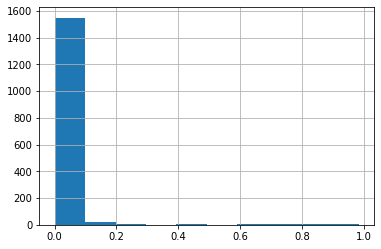

In [36]:
strat_train['instrumentalness'].hist()
# Long tail for the remaining values (>0) ..

In [37]:
#Feature 14: liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. #
#A value above 0.8 provides strong likelihood that the track is live.
strat_train['liveness'].value_counts(dropna = False,normalize=True)

0.1040    0.013125
0.1110    0.011875
0.1180    0.011250
0.1070    0.010000
0.1080    0.010000
            ...   
0.0394    0.000625
0.0924    0.000625
0.0693    0.000625
0.0272    0.000625
0.0457    0.000625
Name: liveness, Length: 696, dtype: float64

<AxesSubplot:>

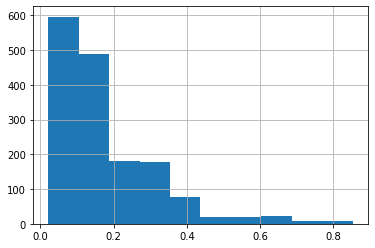

In [38]:
strat_train['liveness'].hist()

In [39]:
#Feature 15: valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), 
#while tracks with low valence sound more negative (e.g. sad, depressed, angry).
strat_train['valence'].value_counts(dropna = False)

0.4180    9
0.7400    8
0.8010    7
0.7160    7
0.8000    6
         ..
0.8780    1
0.7980    1
0.1610    1
0.0902    1
0.9120    1
Name: valence, Length: 701, dtype: int64

In [40]:
strat_train['valence'].describe()

count    1600.000000
mean        0.555401
std         0.223443
min         0.038100
25%         0.391000
50%         0.565000
75%         0.739250
max         0.973000
Name: valence, dtype: float64

In [41]:
#Feature 16: tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, 
#tempo is the speed or pace of a given piece and derives directly from the average beat duration.
strat_train['tempo'].describe()

count    1600.000000
mean      119.533962
std        26.584293
min        62.876000
25%        98.073750
50%       120.001000
75%       133.601750
max       210.851000
Name: tempo, dtype: float64

# The remaining three features are pure text. We need to think about in ways which we can include them in the model

In [42]:
#Feature 17 - Genre
strat_train['genre'].value_counts(dropna=False)

pop                                    334
hip hop, pop                           219
hip hop, pop, R&B                      206
pop, Dance/Electronic                  174
pop, R&B                               145
                                      ... 
World/Traditional, Folk/Acoustic         1
country, latin                           1
rock, Folk/Acoustic, pop                 1
pop, R&B, easy listening                 1
rock, Folk/Acoustic, easy listening      1
Name: genre, Length: 53, dtype: int64

In [43]:
strat_train['artist'].nunique()

724

In [44]:
strat_train['artist'].value_counts(dropna=False).sort_values(ascending=False)

Rihanna             22
Calvin Harris       16
Drake               16
Eminem              16
Britney Spears      15
                    ..
Stromae              1
Lil Baby             1
Robin Thicke         1
Tinchy Stryder       1
Lost Frequencies     1
Name: artist, Length: 724, dtype: int64

In [45]:
strat_train['song'].nunique()

1515

In [46]:
strat_train['song'].value_counts(dropna=False).sort_values(ascending = False)

Sorry                            4
Breathe                          3
Rise                             3
Mercy                            3
It's My Life                     3
                                ..
Hate It Or Love It               1
Full Moon                        1
Sick Boy                         1
Run It! (feat. Juelz Santana)    1
Stupid Girls                     1
Name: song, Length: 1515, dtype: int64

# As we have completed univariate analysis, we can now move in depth and do some bivariate and multivariate analysis

In [47]:
Corr_matrix = strat_train.corr()
Corr_matrix

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,age
duration_ms,1.000000,0.121697,-0.308814,0.056275,-0.063604,-0.068375,0.000480,-0.071755,-0.010464,0.085275,0.004928,-0.006891,0.017022,-0.118045,-0.014440,0.308814
explicit,0.121697,1.000000,0.078208,0.045488,0.241506,-0.148297,0.029696,-0.084562,0.042836,0.444377,-0.024219,-0.082245,0.009181,-0.048438,0.025618,-0.078208
year,-0.308814,0.078208,1.000000,0.008469,0.044399,-0.105435,-0.008335,0.032490,0.006230,-0.002124,0.024291,-0.059257,-0.024894,-0.212064,0.070800,-1.000000
popularity,0.056275,0.045488,0.008469,1.000000,0.007167,-0.012569,0.008166,0.036429,-0.011664,0.014671,0.024236,-0.039802,-0.023288,-0.020748,0.017189,-0.008469
danceability,-0.063604,0.241506,0.044399,0.007167,1.000000,-0.106320,0.066112,-0.026741,-0.077434,0.139176,-0.071199,0.009328,-0.112715,0.409268,-0.165223,-0.044399
energy,-0.068375,-0.148297,-0.105435,-0.012569,-0.106320,1.000000,-0.003976,0.654370,-0.029439,-0.058110,-0.465835,0.036929,0.150761,0.325159,0.172367,0.105435
key,0.000480,0.029696,-0.008335,0.008166,0.066112,-0.003976,1.000000,-0.017005,-0.150485,0.030669,-0.017547,0.009700,-0.025899,0.044434,-0.004253,0.008335
loudness,-0.071755,-0.084562,0.032490,0.036429,-0.026741,0.654370,-0.017005,1.000000,-0.018815,-0.068847,-0.330996,-0.093066,0.096794,0.233365,0.087247,-0.032490
mode,-0.010464,0.042836,0.006230,-0.011664,-0.077434,-0.029439,-0.150485,-0.018815,1.000000,-0.003984,0.007956,-0.042678,0.013895,-0.097018,0.051145,-0.006230
speechiness,0.085275,0.444377,-0.002124,0.014671,0.139176,-0.058110,0.030669,-0.068847,-0.003984,1.000000,-0.004349,-0.071093,0.063841,0.070904,0.067043,0.002124


<AxesSubplot:>

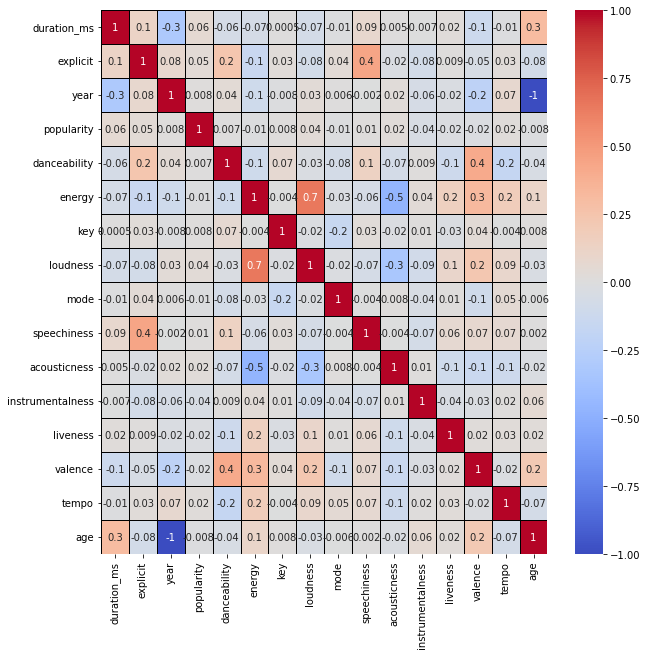

In [48]:
# Viewing the same correlation matrix in a fancy way
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(strat_train.corr(),annot = True,fmt='.1g',cmap= 'coolwarm',linewidths=1, linecolor='black')

# Looks like none of the features are strongly correlated to the 'popularity'. And generally there are no strong associations between other features as well. So, I dont think we can get a high accuracy with these features. But we shall do our best and try different models

# Before Modelling we shall try a few more explorations 

array([[<AxesSubplot:xlabel='popularity', ylabel='popularity'>,
        <AxesSubplot:xlabel='age', ylabel='popularity'>,
        <AxesSubplot:xlabel='energy', ylabel='popularity'>,
        <AxesSubplot:xlabel='loudness', ylabel='popularity'>,
        <AxesSubplot:xlabel='tempo', ylabel='popularity'>,
        <AxesSubplot:xlabel='valence', ylabel='popularity'>,
        <AxesSubplot:xlabel='danceability', ylabel='popularity'>],
       [<AxesSubplot:xlabel='popularity', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='energy', ylabel='age'>,
        <AxesSubplot:xlabel='loudness', ylabel='age'>,
        <AxesSubplot:xlabel='tempo', ylabel='age'>,
        <AxesSubplot:xlabel='valence', ylabel='age'>,
        <AxesSubplot:xlabel='danceability', ylabel='age'>],
       [<AxesSubplot:xlabel='popularity', ylabel='energy'>,
        <AxesSubplot:xlabel='age', ylabel='energy'>,
        <AxesSubplot:xlabel='energy', ylabel='energy'>,
        <AxesSubplot

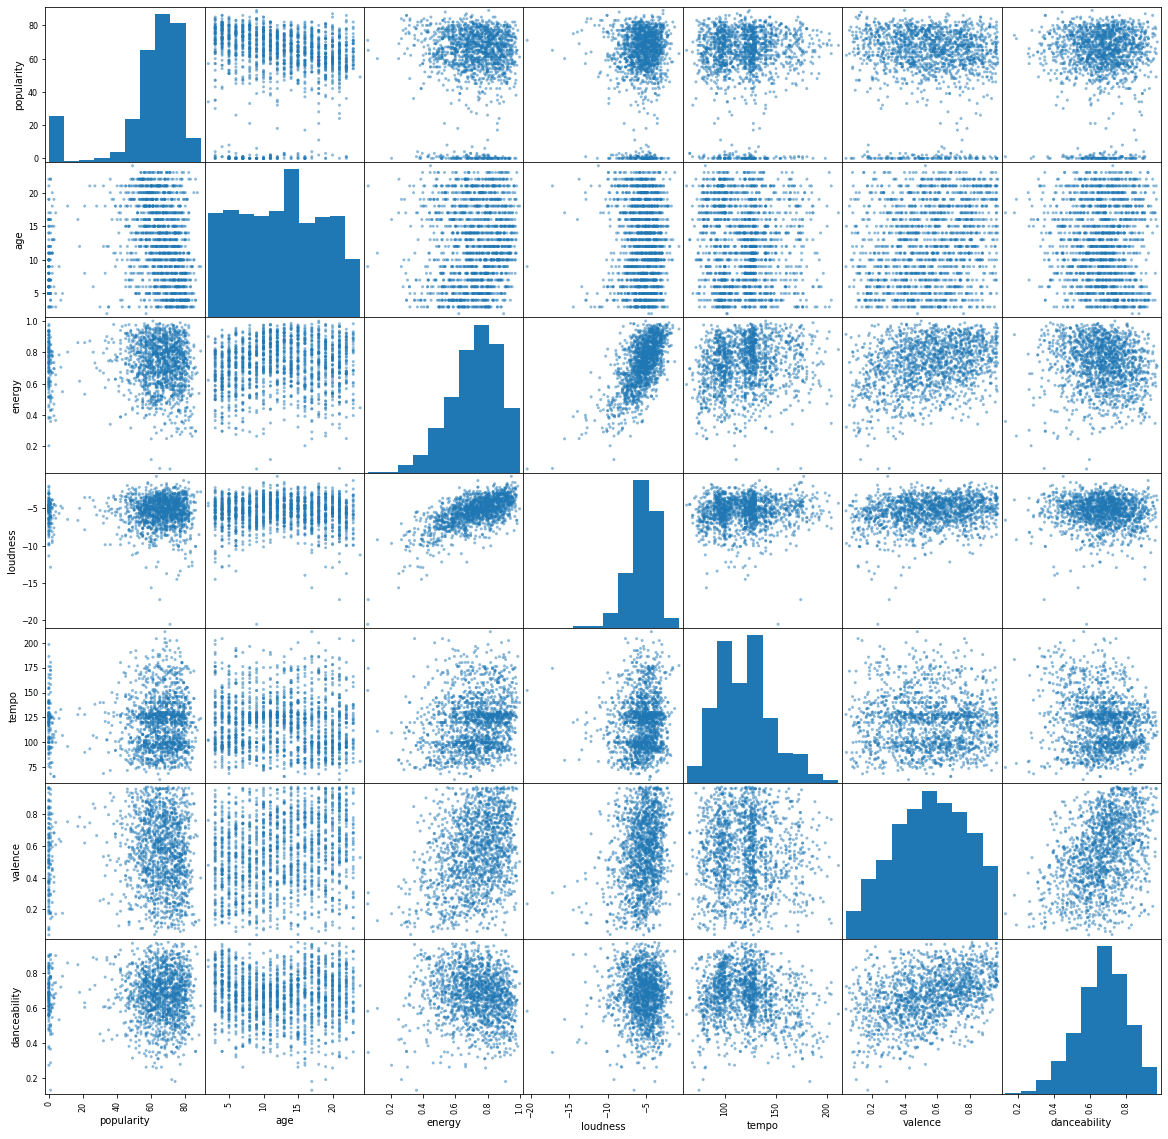

In [49]:
from pandas.plotting import scatter_matrix

attributes = ['popularity','age','energy','loudness','tempo','valence','danceability']
scatter_matrix(strat_train[attributes],figsize=(20,20))

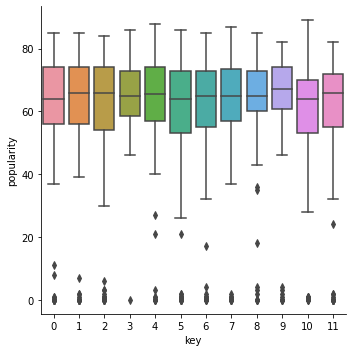

In [50]:
sns.catplot(x="key", y="popularity", kind="box", data=strat_train)

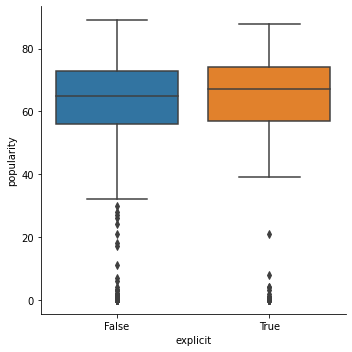

In [51]:
sns.catplot(x="explicit", y="popularity", kind="box", data=strat_train)

In [52]:
text_cols = ['song','artist','genre']
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(x):
    """custom function to remove the punctuation"""
    return x.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def text_clean(x):
    strat_train[x]= strat_train[x].str.lower()
    strat_train[x] = strat_train[x].apply(lambda x: remove_punctuation(x))
    
    
def remove_stopwords(x):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(x).split() if word not in STOPWORDS])


    
    
text_clean('genre')
text_clean('song')
text_clean('artist')
strat_train['genre'] = strat_train['genre'].apply(lambda x: remove_stopwords(x))
strat_train['song'] = strat_train['song'].apply(lambda x: remove_stopwords(x))
strat_train['artist'] = strat_train['artist'].apply(lambda x: remove_stopwords(x))
strat_test['genre'] = strat_test['genre'].apply(lambda x: remove_stopwords(x))
strat_test['song'] = strat_test['song'].apply(lambda x: remove_stopwords(x))
strat_test['artist'] = strat_test['artist'].apply(lambda x: remove_stopwords(x))

   


In [53]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

strat_train["genre"] = strat_train["genre"].apply(lambda text: stem_words(text))
strat_train["song"] = strat_train["song"].apply(lambda text: stem_words(text))
## for artist name we need not do this process
strat_test["genre"] = strat_test["genre"].apply(lambda text: stem_words(text))
strat_test["song"] = strat_test["song"].apply(lambda text: stem_words(text))


In [54]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


strat_train["genre"] = strat_train["genre"].apply(lambda text: lemmatize_words(text))
strat_train["song"] = strat_train["song"].apply(lambda text: lemmatize_words(text))

strat_test["genre"] = strat_test["genre"].apply(lambda text: lemmatize_words(text))
strat_test["song"] = strat_test["song"].apply(lambda text: lemmatize_words(text))


In [55]:
strat_train.columns

Index(['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'genre', 'popularity_rev', 'age', 'age_rev'], dtype='object')

# Setting up ML Pipeline

In [56]:
## Variable options to try - Believe we have to try out different combination of variables and check accuracy

option1_all_wo_text = [ 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity_rev','age_rev']
option2_all_w_text = ['artist', 'song','genre', 'duration_ms', 'explicit', 'year',  'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity_rev', 'age', 'age_rev']
#option3



In [57]:
X1 = strat_train[option2_all_w_text]
X2 = strat_train[option1_all_wo_text]

y=strat_train['popularity_rev']

In [58]:
X1_test = strat_test[option2_all_w_text]
X2_test = strat_test[option1_all_wo_text]

y_test=strat_test['popularity_rev']

In [59]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1212 to 187
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   artist            1600 non-null   object  
 1   song              1600 non-null   object  
 2   genre             1600 non-null   object  
 3   duration_ms       1600 non-null   int64   
 4   explicit          1600 non-null   bool    
 5   year              1600 non-null   int64   
 6   danceability      1600 non-null   float64 
 7   energy            1600 non-null   float64 
 8   key               1600 non-null   int64   
 9   loudness          1600 non-null   float64 
 10  mode              1600 non-null   int64   
 11  speechiness       1600 non-null   float64 
 12  acousticness      1600 non-null   float64 
 13  instrumentalness  1600 non-null   float64 
 14  liveness          1600 non-null   float64 
 15  valence           1600 non-null   float64 
 16  tempo             1600

In [60]:
y.value_counts(dropna=False)

0    1063
1     537
Name: popularity_rev, dtype: int64

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">  
   Setting up required column transformers

In [61]:
ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder()
scaler = StandardScaler()
vect = CountVectorizer()
#regr = LinearRegression()
logreg = LogisticRegression(solver='liblinear',multi_class='auto', random_state=1,max_iter=1000 )

In [62]:
ct = make_column_transformer(
    (ohe, ['explicit', 'key']),
    (oe,['age_rev']),
    (scaler, ['duration_ms', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']),
    remainder='drop')

In [63]:
## Pipeline for Logistic Regression Classification problem

pipe_LR = make_pipeline(ct, logreg)
pipe_LR.fit(X2,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_rev']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                  

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">  
Cross validation of Logistic Regression

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

cross_val_score(pipe_LR, X2, y, cv=cv, scoring='accuracy').mean()

0.6789583333333333

In [65]:
params = {}
params['logisticregression__penalty'] = ['l1', 'l2']
params['logisticregression__C'] = [0.1, 1, 10]
params

{'logisticregression__penalty': ['l1', 'l2'],
 'logisticregression__C': [0.1, 1, 10]}

In [66]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe_LR, params, cv=cv, scoring='accuracy')
grid.fit(X2, y);

In [67]:
results = pd.DataFrame(grid.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012641,0.000489,0.005515,0.000096,0.1,l1,"{'logisticregression__C': 0.1, 'logisticregres...",0.69375,0.66875,0.70625,0.70625,0.68750,...,0.72500,0.70000,0.63750,0.66250,0.66250,0.68125,0.71250,0.72500,0.69375,0.686250,0.026780,1
1,0.015232,0.000256,0.005655,0.000119,0.1,l2,"{'logisticregression__C': 0.1, 'logisticregres...",0.70625,0.65625,0.71875,0.70000,0.68125,...,0.72500,0.70625,0.64375,0.67500,0.66875,0.69375,0.70625,0.71875,0.66875,0.683750,0.028349,2
2,0.024586,0.002909,0.006259,0.000440,1,l1,"{'logisticregression__C': 1, 'logisticregressi...",0.70000,0.66250,0.71250,0.70000,0.68125,...,0.70000,0.70625,0.63750,0.66875,0.66875,0.69375,0.71250,0.71875,0.67500,0.681875,0.027212,3
4,0.106682,0.020950,0.007128,0.000231,10,l1,"{'logisticregression__C': 10, 'logisticregress...",0.70625,0.65625,0.71250,0.70000,0.67500,...,0.69375,0.70625,0.63750,0.66875,0.66875,0.68750,0.71250,0.70625,0.66875,0.679167,0.028428,4
3,0.015761,0.000508,0.005692,0.000278,1,l2,"{'logisticregression__C': 1, 'logisticregressi...",0.70625,0.65625,0.71250,0.70000,0.67500,...,0.69375,0.70625,0.63750,0.66875,0.66875,0.68750,0.71250,0.70625,0.66875,0.678958,0.028251,5
5,0.015868,0.000682,0.005638,0.000328,10,l2,"{'logisticregression__C': 10, 'logisticregress...",0.70625,0.65625,0.71875,0.70000,0.66875,...,0.69375,0.70625,0.63750,0.66875,0.66875,0.68750,0.71250,0.70625,0.66250,0.678750,0.028623,6


In [68]:
grid.best_score_

0.68625

In [69]:
grid.best_params_

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ct_withtext = make_column_transformer(
    (ohe, ['explicit', 'key']),
    (vect, 'genre','artist','song'),
    (TfidfVectorizer(), 'genre','artist','song'),
    (oe,['age_rev']),
    (scaler, ['duration_ms', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']),
    remainder='drop')

# 

In [71]:
pipe_LR = make_pipeline(ct_withtext, logreg)
pipe_LR.fit(X1,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('countvectorizer',
                                                  CountVectorizer(), 'genre'),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(), 'genre'),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_rev']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                   

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

cross_val_score(pipe_LR, X1, y, cv=cv, scoring='f1').mean()

0.3695821391953554

# Let's try RF

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
RF = RandomForestClassifier()
pipe_RF = make_pipeline(ct_withtext, RF)
pipe_RF.fit(X1,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('countvectorizer',
                                                  CountVectorizer(), 'genre'),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(), 'genre'),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_rev']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                   

In [75]:
cross_val_score(pipe_RF, X1, y, cv=cv, scoring='f1').mean()

0.3952533193584824

# XG Boost

In [76]:
from xgboost import XGBClassifier
XGB = XGBClassifier()

In [77]:
pipe_XGB = make_pipeline(ct_withtext, XGB)
pipe_XGB.fit(X1,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key']),
                                                 ('countvectorizer',
                                                  CountVectorizer(), 'genre'),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(), 'genre'),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['age_rev']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                   

In [78]:
cross_val_score(pipe_XGB, X1, y, cv=cv, scoring='f1').mean()

0.4529692145144735

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#1042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;
              color:white; 
                  text-align:center;">  
Predicting it in the test data that we kept aside earlier

In [79]:
LR_Pred =  pipe_LR.predict(strat_test)
RF_Pred =  pipe_RF.predict(strat_test)
XGB_Pred = pipe_XGB.predict(strat_test)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
print(classification_report(y_test,LR_Pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       266
           1       0.47      0.31      0.37       134

    accuracy                           0.65       400
   macro avg       0.59      0.57      0.57       400
weighted avg       0.63      0.65      0.63       400



In [81]:
print(classification_report(y_test,RF_Pred))

              precision    recall  f1-score   support

           0       0.70      0.87      0.78       266
           1       0.50      0.26      0.34       134

    accuracy                           0.67       400
   macro avg       0.60      0.56      0.56       400
weighted avg       0.63      0.67      0.63       400



In [82]:
print(classification_report(y_test,XGB_Pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       266
           1       0.47      0.37      0.41       134

    accuracy                           0.65       400
   macro avg       0.59      0.58      0.58       400
weighted avg       0.63      0.65      0.64       400

